# Original

In [1]:
%run food_item_info.ipynb
%run evaluation_notebook.ipynb
import random
types = ['Pantry', 'Refrigerate', 'Freeze']
tips = ''
nlp = spacy.load(MODEL_PATH)
allFoodTweets = []
# rangeTweets = [5,7]
rangeTweets = [0,3]
for i in range(rangeTweets[0], rangeTweets[1]):
    myTweet = test_data['tweet'][i]
    x = nlp(preProcess(myTweet))
    # splitSent = myTweet.split()
    allFoodTweets.append(x.doc.ents)

counter = rangeTweets[0]
for entities in allFoodTweets:
    if counter != rangeTweets[1]:
        myTweet = test_data['tweet'][counter]
        ent_recognize(preProcess(myTweet))
        print("Total Entities found: ", entities)
        counter += 1
    for e in entities:
        item = repr(e)
        print(item)
        if entityFound(item):
            for t in types: print(foodStorage(item, t))
        else: print('entity not found!')

# displayTipsByTweet(test_data)

Total Entities found:  (chicken, milk)
chicken
['No Tip to give!']
['The Date of Perish for Chicken is from 1 to 2 Days']
['The Date of Perish for Chicken is 12 Months']
milk
['No Tip to give!']
['Refrigerate is Package use-by date']
['The Date of Perish for Milk is 3 Months']


Total Entities found:  (milk,)
milk
['No Tip to give!']
['Refrigerate is Package use-by date']
['The Date of Perish for Milk is 3 Months']


C:\ProgramData\Anaconda3\lib\site-packages\spacy\displacy\__init__.py:200: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


Total Entities found:  ()


# Experimenting Using SpaCy similarity_scores()

In [1]:
#from gensim.summarization.summarizer import summarize
#from gensim.summarization import keywords as extract_keywords

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords

import spacy

import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import time

### Relevant functions

In [2]:
def get_surrounding_words(sentence, ents):    
    words = []
    
    for w in sentence.split():
        words.append(w)
        
    # Filtering out:
    # 1) Keywords from keyword_ that have NO synset, because we need words with synset in order to perform word similarity
    # 2) Keywords that are not actual entities detected (Because we want to extract keywords SURROUNDING the entities)
    words = [w for w in words if len(wordnet.synsets(w)) > 0 and w not in ents]

    # Filtering stopwords
    stops = stopwords.words('english')
    words = [w for w in words if w not in stops]
    
    # Part of speech tagging (We want only nouns, and verbs - However this is bound to change)
    prefered_pos = ['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN',  'VBP', 'VBZ']
    # prefered_pos = ['VB', 'VBD', 'VBG', 'VBN',  'VBP', 'VBZ']
    tagged = nltk.pos_tag(words)

    words = []
    for word, pos in tagged:    
        if pos in prefered_pos:
            words.append(word)
    
    return words # Array of words being returned

def get_cooking_similarity(context_words: list):
    if len(context_words) == 0: # Empty list
        return {'': 0}
    
    cooking_keywords = ["cook", "cooking", "recipe", "ingredient"]
    # cooking_keywords = ["cook", "cooking", "cooked"]
    nlp_word_sim = spacy.load('en_core_web_md') # Another spacy nlp model for word similarity
    
    similarity_scores = dict()
    
    for current_word in context_words:        
        cooking_similarity_dict = dict()        
        current_token = nlp_word_sim(current_word)
        
        for cook_word in cooking_keywords:
            # Comparing current word with cooking words: "cook", "cooking", "recipe", "ingredient".
            # Get the corresponding cooking word with the highest score
            cook_token = nlp_word_sim(cook_word)
                
            cooking_similarity_dict[cook_word] = cook_token.similarity(current_token)
        
        highest_cooking_word = max(cooking_similarity_dict, key=cooking_similarity_dict.get)
        similarity_scores[current_word] = cooking_similarity_dict[highest_cooking_word]
    
    return similarity_scores

def is_related_to_cooking(similarity_scores, threshold):
    highest_corr_word = max(similarity_scores, key=similarity_scores.get)
    highest_score = similarity_scores[highest_corr_word]
    print(f'Highest correlated word \'{highest_corr_word}\': {highest_score} similarity rate')
    
    if highest_score >= threshold:
        return True
    else:
        return False

def generate_response(tweet, entities, thresh_value):
    if len(entities) == 0:
        print('No tips to give!')
    else:
        types = ['Pantry', 'Refrigerate', 'Freeze']
        ents_str = [e.text for e in entities] # Convert tuple of <class 'spacy.tokens.span.Span'> to list of entity strings

        # Retrieving words surrounding each entity
        filtered_words = get_surrounding_words(tweet, ents_str)

        # Retrieving Similarity Scores (SpaCy)
        similarity_scores = get_cooking_similarity(filtered_words)

        # Identify if our sentence (Based on context is related to cooking)
        if is_related_to_cooking(similarity_scores, threshold=thresh_value):
            for e in entities:
                item = repr(e)
                print(item)
                if entityFound(item):
                    for t in types:
                        print(foodStorage(item, t))
                else: print('Entity not found in our dataset!')
        else:
            print('Context of this sentence is not relevant to give a tip')

### Numerical analysis on our responses algorithm

In [5]:
%run food_item_info.ipynb
%run evaluation_notebook.ipynb

def make_predictions(df, model_path, threshold):
    start_time = time.time()
    predictions = []
    
    types = ['Pantry', 'Refrigerate', 'Freeze']
    tips = ''
    nlp = spacy.load(model_path)
    allFoodTweets = [] 
    rangeTweets = [0, len(df)]

    # Getting all entities from each Spacy Document
    for i in range(rangeTweets[0], rangeTweets[1]):
        myTweet = df['tweet'][i]
        x = nlp(preProcess(myTweet))
        allFoodTweets.append(x.doc.ents)
    
    counter = rangeTweets[0]
    for entities in allFoodTweets:
        if counter != rangeTweets[1]:
            myTweet = df['tweet'][counter]
            preprocessed_tweet = preProcess(myTweet)

            if len(entities) == 0:
                predictions.append(0)
            else:
                ents_str = [e.text for e in entities] # Convert tuple of <class 'spacy.tokens.span.Span'> to list of entity strings
                filtered_words = get_surrounding_words(preprocessed_tweet, ents_str)
                
                # Finding Similarity Scores (SpaCy)
                similarity_scores = get_cooking_similarity(filtered_words)

                # Finding corresponding word with highest similarity score form 'cook'
                highest_corr_word = max(similarity_scores, key=similarity_scores.get)
                highest_score = similarity_scores[highest_corr_word]

                # If highest_score >= threshold, then this sentence is likely most relevant to cooking, so give tips
                if highest_score >= threshold:
                    predictions.append(1)
                else:
                    predictions.append(0)

        counter += 1
    
    print(f'------------------------Elapsed time {time.time() - start_time} seconds------------------------')
    return predictions

ground_truths = pd.read_csv('datasets/responses_ground_truth.csv')
predictions = make_predictions(ground_truths, MODEL_PATH, 0.85)

------------------------Elapsed time 66.97978806495667 seconds------------------------


Accuracy: 0.9397590361445783
Precision: 0.2857142857142857
Recall: 1.0
F1: 0.4444444444444445


[Text(0.5, 25.722222222222214, 'Predicted (Our Algorithm)'),
 Text(33.22222222222222, 0.5, 'Actual Labels'),
 [Text(0.5, 0, 'Not Cooking Realted'), Text(1.5, 0, 'Cooking Related')],
 [Text(0, 0.5, 'Not Cooking Related'), Text(0, 1.5, 'Cooking Related')]]

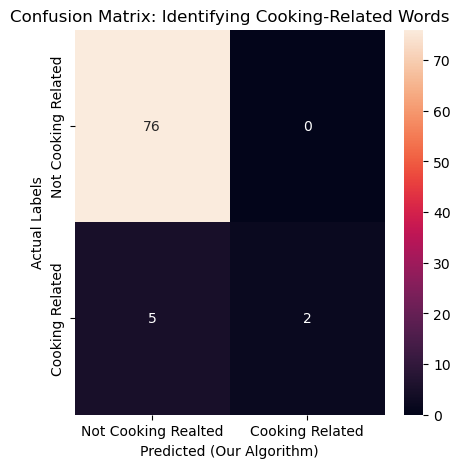

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

actual = ground_truths['cooking related']

print(f'Accuracy: {accuracy_score(predictions, actual)}')
print(f'Precision: {precision_score(predictions, actual)}')
print(f'Recall: {recall_score(predictions, actual)}')
print(f'F1: {f1_score(predictions, actual)}')

cf_matrix = confusion_matrix(actual, predictions)
plt.figure(figsize = (5,5))
plt.title("Confusion Matrix: Identifying Cooking-Related Words")
ht_mp = sns.heatmap(cf_matrix, annot=True)
ht_mp.set(xlabel='Predicted (Our Algorithm)', ylabel='Actual Labels', 
          xticklabels=['Not Cooking Realted', 'Cooking Related'], 
          yticklabels=['Not Cooking Related', 'Cooking Related'])

### ROC (Receiver Operating Characteristic) of Our Predictions

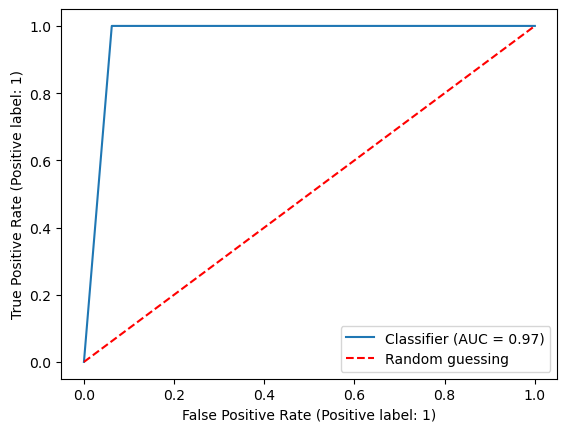

Our Area Under the Curve 0.9691358024691358


In [7]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

RocCurveDisplay.from_predictions(predictions, actual)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random guessing')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import roc_auc_score
print(f'Our Area Under the Curve {roc_auc_score(predictions, actual)}')

### This cell showcases output of how an idea algorithm would behave in generating potential responses

In [8]:
%run food_item_info.ipynb
%run evaluation_notebook.ipynb

types = ['Pantry', 'Refrigerate', 'Freeze']
tips = ''
nlp = spacy.load(MODEL_PATH)
allFoodTweets = [] 
rangeTweets = [40,50]

# Getting all entities from each Spacy Document
for i in range(rangeTweets[0], rangeTweets[1]):
    myTweet = test_data['tweet'][i]
    x = nlp(preProcess(myTweet))
    allFoodTweets.append(x.doc.ents)
    
counter = rangeTweets[0]
for entities in allFoodTweets:
    if counter != rangeTweets[1]:
        myTweet = test_data['tweet'][counter]
        preprocessed_tweet = preProcess(myTweet)
        ent_recognize(preprocessed_tweet)
        print("Total Entities found: ", entities)
        
        generate_response(preprocessed_tweet, entities, thresh_value=0.85)
        print('=' * 100)
        
        counter += 1

Total Entities found:  ()
No tips to give!


Total Entities found:  (chocolate, chocolate)
Highest correlated word 'situations': 0.3613373566876426 similarity rate
Context of this sentence is not relevant to give a tip


Total Entities found:  (chocolate,)
Highest correlated word 'trying': 0.3987879793293425 similarity rate
Context of this sentence is not relevant to give a tip


Total Entities found:  ()
No tips to give!


Total Entities found:  ()
No tips to give!


Total Entities found:  ()
No tips to give!


Total Entities found:  (buttermilk, flour)
Highest correlated word 'recipe': 1.0 similarity rate
buttermilk
['No Tip to give!']
['The Date of Perish for Buttermilk is from 1 to 2 Weeks']
['The Date of Perish for Buttermilk is 3 Months']
flour
['The Date of Perish for Flour is from 6 to 12 Months']
['Flour can be stored after opened in the Refrigerate for 1 Year', 'Refrigerate is Year']
['No Tip to give!']


Total Entities found:  (popcorn, chocolate)
Highest correlated word 'fruitcake': 0.5112564480543528 similarity rate
Context of this sentence is not relevant to give a tip


Total Entities found:  (peas, onions, beets)
Highest correlated word 'garden': 0.4448941229063069 similarity rate
Context of this sentence is not relevant to give a tip


Total Entities found:  ()
No tips to give!


# Twitter API

In [15]:
# import twint
# import pandas as pd
# from datetime import date

# today = date.today()

# c = twint.Config()
# c.Lang = "en"
# # c.Search = "#foodwaste" or "#zerowaste" or "#sustainability" or "#ecofriendly"
# # c.Limit = 20
# c.Username = "edward09690585"
# c.Since = "2017-1-1"
# c.until= today.strftime("%b-%d-%Y")

# c.Store_csv = True
# c.Custom_csv = ["date", "time", "username", "tweet", "link", "likes", "retweets", "replies", "mentions", "hashtags"]
# c.Pandas = True
# c.Output = "eco1friendly.csv"

# #dataframes.append(df)


# twint.run.Search(c)

In [23]:
import pandas as pd

LIVE_TWITTER_DATA_PATH = "eco1friendly.csv"

recent_tweets = pd.read_csv(LIVE_TWITTER_DATA_PATH)
recent_tweets.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1511205194175942659,1511205194175942659,2022-04-04 21:52:49 Pacific Daylight Time,2022-04-04,21:52:49,-700,1511082642589986819,edward09690585,edward,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1511204037223337986,1511204037223337986,2022-04-04 21:48:13 Pacific Daylight Time,2022-04-04,21:48:13,-700,1511082642589986819,edward09690585,edward,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1511203496317505538,1511203496317505538,2022-04-04 21:46:04 Pacific Daylight Time,2022-04-04,21:46:04,-700,1511082642589986819,edward09690585,edward,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [24]:
new_data = recent_tweets['tweet']
new_data.head()


0    I had this amazing watermelon for a snack toda...
1    Does anyone know how long it takes for milk to...
2    I had eggs and bacon for breakfast, it was del...
Name: tweet, dtype: object

In [18]:
import re
def preProcessLocal(tweet):
    #Converts a tweet to lowercase, replaces anyusername w/ <USERNAME> and URLS with <URL>
    tweet = tweet.lower()
    tweet = re.sub('@[a-zA-z0-9]*', '', tweet)              # <USERNAME>
    tweet = re.sub('http[a-zA-z0-9./:]*', '', tweet)       # <URL>
    tweet = re.sub('[.,-]*', '', tweet)
    
    # Utilize for instragram posts, remove hashtag for food-related posts
    tweet = re.sub(r'#[a-zA-z0-9]*', '', tweet)
    # tweet = re.sub(r'#', '', tweet) 
    
    tweet = re.sub('&amp;', 'and', tweet)
    return tweet
# print(preProcessLocal(recent_tweets['tweet'][0]))

In [35]:
nlp = spacy.load(MODEL_PATH)
allFoodTweets = []
allTips = []
tipsByItem = {}
# rangeTweets = [150,155]
rangeTweets = [0,1]
for i in range(rangeTweets[0], rangeTweets[1]):
    myTweet = recent_tweets['tweet'][i]
    x = nlp(preProcessLocal(myTweet))
    allFoodTweets.append(x.doc.ents)

counter = rangeTweets[0]
for entities in allFoodTweets:
    if counter != rangeTweets[1]:
        myTweet = recent_tweets['tweet'][counter]
        ent_recognize(preProcessLocal(myTweet))
        print("Total Entities found: ", entities)
        counter += 1
    for e in entities:
        item = repr(e)
        print(item)
        if entityFound(item):
            for t in types:
                allTips.append(foodStorage(item, t))
                print(foodStorage(item, t))
        else: print('entity not found!')

Total Entities found:  (watermelon,)
watermelon
['The Date of Perish for Watermelon is from 1 to 2 Days', 'A Watermelon tip about the Date of Perish is Or until ripe.']
['The Date of Perish for Watermelon is from 3 to 4 Days']
['Watermelon can be stored in the Freeze for 12 Months']


In [20]:
print(allTips)

[['No Tip to give!'], ['Refrigerate is Package use-by date'], ['The Date of Perish for Milk is 3 Months']]


In [38]:
import tweepy

BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAABo6aAEAAAAA%2F0WLmPGia05j9gEC2CFXG0OsJlk%3DlvFsgAI9eeHUlIAQl371gYanqn0h6Eaf5VqNjBO4tmSugGFhxA'

API_KEY = 'FzCPF6KXbHSXtgWW90dWkwceU'
API_SECRET_KEY = 'SsVhnggj0TJN3DZ0yEJajJVUT9M2xkfghaUaF2iw6HfCr00qhf'

ACCESS_TOKEN = '1501693154507968514-o5KYtx4GOTX7FPj1OHINQU2q1J50KU'
ACCESS_SECRET_TOKEN = '1ZYbyPj5qN35kOVZ4R8JHEQq0ChroueMd15Q9UIzOTiTG'

client = tweepy.Client(
    bearer_token= BEARER_TOKEN,
    consumer_key = API_KEY,
    consumer_secret = API_SECRET_KEY,
    access_token = ACCESS_TOKEN,
    access_token_secret = ACCESS_SECRET_TOKEN
)

# find tweet by id
# tweet = client.get_tweet(id=1511098408768995332)

# extract data from tweet
# text = tweet.data
# print(text)
userNames = '@' + recent_tweets['username'][0] + ' '
results = ''
# print(results)
# dict = {'item' : 'tip'}
for tips in allTips:
    for t in tips:
        if t != 'No Tip to give!':
            results += t + '. '
    # res = client.create_tweet(text=results)
    # print(res)

new_food_tweet = client.create_tweet(text=userNames + results + ' - USDA FoodKeeper Tips')
print(results)
print('Char Count: ', len(results))
# new_food_tweet = client.create_tweet(text=results)

print(new_food_tweet)

# Authenticate to Twitter
# auth = tweepy.OAuthHandler(API_KEY, API_SECRET_KEY)
# auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET_TOKEN)

# api = tweepy.API(auth)

# public = api.home_timeline()
# print(public[0].text)

# try:
#     api.verify_credentials()
#     print("Authentication OK")
# except:
#     print("Error during authentication")

# results = ''
# for tips in allTips:
#     # print(tips)
#     for t in tips:
#         # print(t)
#         results += t + ' '
# res = user.create_tweet(text=results)
# print(res)
# id = res.data["id"]
# user.retweet(tweet_id=id)
# user.like(tweet_id=id)
# print(recent_tweets['id'][0])
# 1511098408768995332
# 1511082996648259585
# 1511098408768995332
# data = user.get_tweet(1511098408768995332)
# data = user.get_tweets(ids=1511098408768995332)
# print(recent_tweets['username'][0])
# u = str(recent_tweets['username'][0])
# data = user.get_user(u)
# id = 1511082996648259585
# tweet = user.get_tweet(id, expansions=['author_id'], user_fields=['username'])
# test = user.follow_user
# print(data)
# data = user.get_users_tweets(id=recent_tweets['id'][0])
# print(data)


The Date of Perish for Watermelon is from 1 to 2 Days. A Watermelon tip about the Date of Perish is Or until ripe.. The Date of Perish for Watermelon is from 3 to 4 Days. Watermelon can be stored in the Freeze for 12 Months. 
Char Count:  225
Response(data={'id': '1511212210587983872', 'text': '@edward09690585 The Date of Perish for Watermelon is from 1 to 2 Days. A Watermelon tip about the Date of Perish is Or until ripe.. The Date of Perish for Watermelon is from 3 to 4 Days. Watermelon can be stored in the Freeze for 12 Months.  - USDA FoodKeeper Tips'}, includes={}, errors=[], meta={})
